<font color = "red"> Binana close contacts! 

#### Overview 

| Task                                      | Description                                                   |
|-------------------------------------------|---------------------------------------------------------------|
| Run Binana                                | Execute Binana for all PDBs and poses                         |
| Read logfile                              | Create a dictionary with information from log files           |
| Getting dict info                         | - Close Contacts [OK] <br> - Hydrogen Bonds                  |
| Extract atom properties (RDkit)           | - Atom Index <br> - Name <br> - Mass <br> - Charge <br> - Element Name <br> - Hybridization <br> - Num Hydrogens <br> - Formal Charge <br> - Unpaired Electron <br> - In Aromatic Substructure |
| Preparing data for graph                  | - protgraph_dict[pdb][pose] = {<br>&nbsp;&nbsp;&nbsp;&nbsp;'x_s': x_s (ligand properties),<br>&nbsp;&nbsp;&nbsp;&nbsp;'x_t': x_t (receptor properties),<br>&nbsp;&nbsp;&nbsp;&nbsp;'edge_index': edge_index (Matrix [2, number of connections]),<br>&nbsp;&nbsp;&nbsp;&nbsp;'edge_attr': edge_attr (Vector [distances])<br>} |
| Protgraph_dict                            | --> BipartiteData data  --> Dataset list  --> DataLoader  --> Graph Attention Model |


* Data spliting methods

### Libraries 

In [1]:
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run ../Config.ipynb

In [3]:
config = Config()

In [4]:
pdbs = os.listdir(config.set)#[:150]
nposes = config.docking_params['nposes']
batch_size  = config.model_args['batch_size']
path_scripts = Path(os.getcwd())
num_epochs = config.model_args['epochs']
num_folds = config.model_args['nfolds']
patience = config.model_args['patience']  # Set your desired patience value
binana_executable = config.executables['binana']

In [5]:
binana_executable

'../executables/binana-2.1/python/run_binana.py'

In [6]:
{config.set}

{'../coreset'}

### Running Binana
<font color = "red"> Só precisa rodar uma vez!

In [ ]:
%%time
def binana(pdb, config):
    os.makedirs(config['output_folder'], exist_ok=True)  # Create the directory path if it doesn't exist
    binana_exec_cmd = f"python3 {binana_executable} -receptor {config['receptor_path']} -ligand {config['ligand_path']} -output_dir {config['output_folder']} > errors.txt"
    os.system(binana_exec_cmd)

receptor = "protein_fixed.pdb"

# Combined loop for both versions
for pdb in tqdm(pdbs, desc="Processing PDBS"):

    config_version_2 = {
    'ligand_path': f"{config.set}/{pdb}/ligand.pdb",
    'output_folder': f"{config.set}/{pdb}/binana/binana_{pdb}",
    'receptor_path': f"{config.set}/{pdb}/{pdb}_{receptor}"
}
    
    for pose in range(1, nposes + 1):
        # Configuration dictionaries for each version
        config_version_1 = {
            'ligand_path':f"{config.set}/{pdb}/results/pose_{pose}.pdb",
            'output_folder': f"{config.set}/{pdb}/binana/binana_{pdb}_pose_{pose}",
            'receptor_path': f"{config.set}/{pdb}/{pdb}_{receptor}"
        }
        try:
            binana(pdb, config=config_version_1)
        except ValueError as e:
            print(e)
            pass
    binana(pdb, config=config_version_2)

Processing PDBS:   0%|                                  | 0/150 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/lbcb02/Workspace/BindRanker/BindRanker/Datafactory/../executables/binana-2.1/python/run_binana.py", line 13, in <module>
    start()
  File "/home/lbcb02/Workspace/BindRanker/BindRanker/Datafactory/../executables/binana-2.1/python/run_binana.py", line 8, in start
    binana.run()
  File "/home/lbcb02/Workspace/BindRanker/BindRanker/executables/binana-2.1/python/binana/__init__.py", line 97, in run
    _start._get_all_interactions(cmd_params)
  File "/home/lbcb02/Workspace/BindRanker/BindRanker/executables/binana-2.1/python/binana/_start.py", line 48, in _get_all_interactions
    ligand, receptor = from_files(
                       ^^^^^^^^^^^
  File "/home/lbcb02/Workspace/BindRanker/BindRanker/executables/binana-2.1/python/binana/load_ligand_receptor/__init__.py", line 105, in from_files
    receptor.load_pdb_file(
  File "/home/lbcb02/Workspace/BindRanker/

284 - PDBs - 29 min! 

### Read logfile

In [7]:
%%time
data_dict_all_logs_exp = defaultdict(dict)
data_dict_all_logs_docked = defaultdict(dict)
def read_logfile(pdb, pose=None):
    # Define the common part of the file path
    common_path = f"{config.set}/{pdb}/binana/binana_{pdb}"
    
    # Adjust the file path based on whether the pose parameter is provided
    path = common_path + (f"_pose_{pose}" if pose is not None else "") + "/log.txt"

     
    try: # Read the text file using Path
        with Path(path).open('r') as file:
            text = file.read()
    
    
        # Extract the content after "JSON Output:"
        json_text = text.split("JSON Output:")[1].strip()
        
        # Convert the JSON text to a dictionary
        data_dict = json.loads(json_text)
        
        # Store the data dictionary for the pose if pose is provided
        if pose is not None:
            data_dict_all_logs_docked[pdb][pose] = data_dict
        else:
            # Store the data dictionary for the pose (from the first code)
            data_dict_all_logs_exp[pdb] = data_dict

    except:
        print("Error when opening file ", path)
    
    return data_dict_all_logs_exp, data_dict_all_logs_docked

# Example usage: provide pose parameter for the second code, leave it empty for the first code
for pdb in pdbs:
    read_logfile(pdb)  # Run logic from the first code
    for pose in range(1, nposes + 1):
        read_logfile(pdb, pose)  # Run logic from the second code

CPU times: user 3.75 s, sys: 507 ms, total: 4.26 s
Wall time: 5.55 s


In [8]:
#data_dict_all_logs_docked.get('2qbq')

### Getting dict info 

In [9]:
%%time
def flatten_data(df, pdb, pose = False):
    flat_data = []
    if pose == False:
        data = df[pdb]['closeContacts']
    else:
        data = df[pdb][pose]['closeContacts']
    
    for entry in data:
        flat_entry = {
            'ligand_atom_index': entry['ligandAtoms'][0]['atomIndex'],
            'ligand_atom_name': entry['ligandAtoms'][0]['atomName'],
            'ligand_chain': entry['ligandAtoms'][0]['chain'],
            'ligand_resID': entry['ligandAtoms'][0]['resID'],
            'ligand_resName': entry['ligandAtoms'][0]['resName'],
            #'angle': entry['metrics']['angle'],
            'distance': entry['metrics']['distance'],
            'receptor_atom_index': entry['receptorAtoms'][0]['atomIndex'],
            'receptor_atom_name': entry['receptorAtoms'][0]['atomName'],
            'receptor_chain': entry['receptorAtoms'][0]['chain'],
            'receptor_resID': entry['receptorAtoms'][0]['resID'],
            'receptor_resName': entry['receptorAtoms'][0]['resName'],
        }
        flat_data.append(flat_entry)

    return pd.DataFrame(flat_data)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 15.7 µs


In [10]:
#data_dict_all_logs_docked.get("2qbq")

In [11]:
%%time
data_frames_exp = [
    flatten_data(data_dict_all_logs_exp, pdb).assign(pdb=pdb)
    for pdb in pdbs
]
data_frame_exp = pd.concat(data_frames_exp, axis=0)

#data_frames_docked = [flatten_data(data_dict_all_logs_docked, pdb, pose).assign(pdb=pdb, pose=str(pose))  for pdb in pdbs  for pose in range(1, nposes)]
#data_frame_docked = pd.concat(data_frames_docked, axis=0)

CPU times: user 809 ms, sys: 346 µs, total: 809 ms
Wall time: 821 ms


In [12]:
data_frame_exp[(data_frame_exp["pdb"] == "4eor")][['pdb','ligand_atom_index','ligand_atom_name','receptor_atom_index','receptor_atom_name','distance']].head()

,pdb,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
0,4eor,1,C2,93,CD1,3.905220
1,4eor,1,C2,639,O,3.697013
2,4eor,1,C2,1055,CD1,3.664254
3,4eor,2,C8,248,CB,3.823513
4,4eor,2,C8,478,CG2,3.238495


In [13]:
%%time
# Create a list of DataFrames with the specified conditions
data_frames_docked = [
    flatten_data(data_dict_all_logs_docked, pdb, pose).assign(pdb=pdb, pose=str(pose))
    for pdb in pdbs
    for pose in range(1, nposes)
    if pose in data_dict_all_logs_docked.get(pdb, {})
]

# Concatenate the DataFrames
data_frame_docked = pd.concat(data_frames_docked, axis=0)

CPU times: user 7.63 s, sys: 52.3 ms, total: 7.68 s
Wall time: 7.69 s


#### Report 

In [14]:
foureor1 = data_frame_docked[(data_frame_docked["pdb"] == "4eor") & (data_frame_docked["pose"] == "1")][['pdb','pose','ligand_atom_index','ligand_atom_name','receptor_atom_index','receptor_atom_name','distance']]

In [15]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
0,4eor,1,1.0,C2,92.0,CG2,3.537490
1,4eor,1,1.0,C2,1056.0,CD2,3.918316
2,4eor,1,3.0,N1,92.0,CG2,3.659126
3,4eor,1,3.0,N1,93.0,CD1,3.711112
4,4eor,1,3.0,N1,639.0,O,3.983377


In [16]:
foureor1['receptor_atom_name'].value_counts()

O      15
CG2    12
CD1     9
C       6
CD2     6
CD      5
CB      5
N       5
CA      4
CG1     4
OE1     3
CE1     3
CZ      3
OE2     2
CE2     2
NZ      2
OD2     1
CG      1
Name: receptor_atom_name, dtype: int64

In [17]:
foureor1['receptor_atom_index'].value_counts().reset_index(name = "count").head(10)

,index,count
0,92.0,8
1,647.0,7
2,1056.0,5
3,639.0,5
4,1055.0,5
5,654.0,4
6,646.0,4
7,75.0,3
8,248.0,3
9,655.0,3


In [18]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
0,4eor,1,1.0,C2,92.0,CG2,3.537490
1,4eor,1,1.0,C2,1056.0,CD2,3.918316
2,4eor,1,3.0,N1,92.0,CG2,3.659126
3,4eor,1,3.0,N1,93.0,CD1,3.711112
4,4eor,1,3.0,N1,639.0,O,3.983377


In [19]:
foureor1[(foureor1["pdb"] == "4eor") & (foureor1["receptor_atom_index"] == 75)]

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
54,4eor,1,22.0,N26,75.0,OE1,3.154884
56,4eor,1,23.0,H18,75.0,OE1,3.140022
59,4eor,1,24.0,H19,75.0,OE1,2.558603


In [20]:
foureor1['ligand_atom_name'].nunique()

27

In [21]:
foureor1['receptor_atom_index'].nunique()

36

In [22]:
#receptor_id_resi_atom = foureor1[["receptor_resID","receptor_atom_index"]]

In [23]:
#receptor_id_resi_atom['receptor_resID'].nunique()

In [24]:
#foureor1.groupby("receptor_resID")['receptor_atom_index'].nunique()

In [25]:
#foureor1.groupby("receptor_resID")['receptor_atom_index'].value_counts()

In [26]:
#foureor1[foureor1['receptor_resID'] ==11][["receptor_resID","receptor_atom_index",'ligand_atom_index', 'receptor_atom_name','receptor_resName']]

In [27]:
df = data_frame_docked.copy()

In [28]:
#df[df['pdb'] == '1owh'].head()

In [29]:
#df['pdb'].nunique()

#### List of indexes  

- Create a dictionary with the **indices** of close-contact atoms.

- This is necessary so that we know from which atoms we should **obtain the properties.**

- Dictionaries for experimental data and for poses obtained through docking, for the comparison **metric of native contacts.**

<font color = "red"> Why i used process_ids to sort the values 

In [30]:
data_frame_docked[data_frame_docked['pdb']== '4eor'].head()

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose
0,1.0,C2,d,0.0,UNN,3.537490,92.0,CG2,A,11.0,ILE,4eor,1
1,1.0,C2,d,0.0,UNN,3.918316,1056.0,CD2,A,131.0,LEU,4eor,1
2,3.0,N1,d,0.0,UNN,3.659126,92.0,CG2,A,11.0,ILE,4eor,1
3,3.0,N1,d,0.0,UNN,3.711112,93.0,CD1,A,11.0,ILE,4eor,1
4,3.0,N1,d,0.0,UNN,3.983377,639.0,O,A,80.0,LEU,4eor,1


In [31]:
%%time
def process_ids(data_frame, pdb,  ligand_column, pose = False):
    if 'pose' in data_frame.columns:
        aux = list(data_frame[(data_frame['pdb'] == pdb) & (data_frame['pose'] == str(pose))][ligand_column])
    else:
        aux = list(data_frame[data_frame['pdb'] == pdb][ligand_column])
    try:
        aux = [int(val) for val in aux]
    except ValueError:
        pass
    return aux

def process_pdb_data(pdbs, data_frame, ligand_column):
    ids = {}
    for pdb in pdbs:
        if 'pose' in data_frame.columns:
            ids[pdb] = {}
            for pose in range(1, nposes + 1):
                ids[pdb][pose] = process_ids(data_frame, pdb,  ligand_column, pose)
        else:
            ids[pdb] = process_ids(data_frame, pdb, ligand_column)
    return ids

# index
ids_lig_with_poses = process_pdb_data(pdbs, data_frame_docked, 'ligand_atom_index')
ids_rec_with_poses  = process_pdb_data(pdbs, data_frame_docked, 'receptor_atom_index')
ids_lig_exp = process_pdb_data(pdbs, data_frame_exp, 'ligand_atom_index')
ids_rec_exp  = process_pdb_data(pdbs, data_frame_exp, 'receptor_atom_index')

## Names
#names_lig_with_poses = process_pdb_data(pdbs, data_frame_docked, 'ligand_atom_name')
#names_rec_with_poses  = process_pdb_data(pdbs, data_frame_docked, 'receptor_atom_name')
#names_lig_exp = process_pdb_data(pdbs, data_frame_exp, 'ligand_atom_name')
#names_rec_exp  = process_pdb_data(pdbs, data_frame_exp, 'receptor_atom_name')

CPU times: user 3min 27s, sys: 302 ms, total: 3min 28s
Wall time: 3min 28s


284 - PDBs - 3 min 26s 

In [33]:
#ids_rec_exp['1owh'][1:10]

In [34]:
#ids_lig_exp['1owh'][1:10]

In [35]:
#ids_rec_with_poses['1owh']

### Compare native contacts

In [36]:
%%time
def compare_graphs(pairs_graph1, pairs_graph2):
    """
    Compare two sets of graph pairs and calculate a similarity score.

    Parameters
    ----------
    pairs_graph1 : list
        List of pairs from the first graph.
    pairs_graph2 : list
        List of pairs from the second graph.

    Returns
    -------
    float
        Percentage similarity between the two graphs.
    """
    common_pairs = [pair for pair in pairs_graph1 if pair in pairs_graph2]
    #print(len(common_pairs))
    similarity_score = (len(common_pairs) / len(pairs_graph2)) * 100
    return similarity_score

score = {}

for pdb in pdbs:
    score[pdb] = {}
    for pose in range(1, nposes + 1):
        pairs_graph1 = list(zip(ids_lig_with_poses[pdb][pose], ids_rec_with_poses[pdb][pose]))
        pairs_graph2 = list(zip(ids_lig_exp[pdb], ids_rec_exp[pdb]))
        score[pdb][pose] = compare_graphs(pairs_graph1, pairs_graph2)

import json 
with open(f"{config.data}/score.json", "w") as json_file:
    json.dump(score, json_file)

CPU times: user 789 ms, sys: 4 µs, total: 789 ms
Wall time: 798 ms


<font color = "yellow"> When i extrated the atom properties, i only extrated for  ids_3gv9_pose_1

Why am i taking this?

     * Because we only want properties from the important nodes

### Extract atom properties

In [37]:
def find_element_index(lst, element):
    """
    Locate the index of the desired element within the list. If the element is not found, return the index of the last item.
    """
    try:
        return lst.index(element)
    except ValueError:
        return len(lst) - 1

In [38]:
class AtomPropertiesExtractor:
    def __init__(self):
        #self.ligand_path = ligand_path
        self.columns = ["Atom_Index", "Name", "Mass", "Charge", "Element_Name", "Hybridization", "Num_Hydrogens", "Formal_Charge", "Unpaired_Electron", "In_Aromatic_Substructure"]
        self.allowable_features = {
            "possible_hybridization_list": ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "UNSPECIFIED"],
            "possible_atoms": ['C', 'S', 'N', 'O', 'H']
        }

    def extract_properties(self, atom_indices, properties_to_extract, path):
        atom_properties_list = []

        with open(path, "r") as pdb_file:
            pdb_data = pdb_file.read()

        molecule = Chem.MolFromPDBFile(path, removeHs=False)

        if molecule is not None:
            for atom_index in atom_indices:
                atom = molecule.GetAtomWithIdx(atom_index - 1)

                atom_properties = {
                    "Atom_Index": atom_index,
                    "Name": atom.GetSymbol(),
                    "Mass": atom.GetMass(),
                    "Charge": atom.GetFormalCharge(),
                    "Element_Name": find_element_index(self.allowable_features['possible_atoms'], str(atom.GetSymbol())),
                    "Hybridization": find_element_index(self.allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
                    "Num_Hydrogens": atom.GetTotalNumHs(),
                    "Formal_Charge": atom.GetFormalCharge(),
                    "Unpaired_Electron": atom.GetNumRadicalElectrons(),
                    "In_Aromatic_Substructure": int(atom.GetIsAromatic())
                }

                atom_properties = {key: atom_properties[key] for key in properties_to_extract}
                atom_properties_list.append(atom_properties)

        atom_properties_df = pd.DataFrame(atom_properties_list, columns=properties_to_extract)
        return atom_properties_df

In [39]:
# Create an instance of the class
atom_ligand_extractor = AtomPropertiesExtractor()
atom_receptor_extractor =  AtomPropertiesExtractor()

In [40]:
#atom_receptor_extractor.extract_properties(ids_lig['3gv9'][2], node_descriptors, ligand_path.as_posix())

#### Dict with atom properties: Ligand and receptor

In [41]:
#extract_atom_properties(ligand_path.as_posix(), ids_lig['3gv9'][2])

In [42]:
#atom_ligand_extractor.extract_properties(ids_lig['3gv9'][1], config.node_descriptors, '/home/lbcb02/Workspace/Scripts/coreset/3gv9/results/pose_1.pdb')

In [43]:
#ids_lig['3gv9'][2]

In [44]:
lig_atoms_prop = {}
rec_atoms_prop = {}
df_dict = {}

In [45]:
df.head()

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose
0,1.0,C2,d,0.0,UNN,3.537490,92.0,CG2,A,11.0,ILE,4eor,1
1,1.0,C2,d,0.0,UNN,3.918316,1056.0,CD2,A,131.0,LEU,4eor,1
2,3.0,N1,d,0.0,UNN,3.659126,92.0,CG2,A,11.0,ILE,4eor,1
3,3.0,N1,d,0.0,UNN,3.711112,93.0,CD1,A,11.0,ILE,4eor,1
4,3.0,N1,d,0.0,UNN,3.983377,639.0,O,A,80.0,LEU,4eor,1


In [46]:
df['receptor_atom_name'].nunique()

79

In [47]:
df['ligand_atom_name'].value_counts().head(10)

C2     5855
C6     5539
C5     5045
C4     4948
C1     4801
C3     4660
C8     4197
H1     4186
C7     4101
C10    3886
Name: ligand_atom_name, dtype: int64

In [48]:
pd.get_dummies(df['receptor_atom_name'], prefix='encoded').head(2)

,encoded_C,encoded_CA,encoded_CB,encoded_CD,encoded_CD1,encoded_CD2,encoded_CE,encoded_CE1,encoded_CE2,encoded_CE3,...,encoded_O,encoded_OD1,encoded_OD2,encoded_OE1,encoded_OE2,encoded_OG,encoded_OG1,encoded_OH,encoded_SD,encoded_SG
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
ids_lig_with_poses[pdb][pose]#[:10]

[]

In [50]:
df['receptor_atom_name']

0     CG2
1     CD2
2     CG2
3     CD1
4       O
     ... 
31     CE
32     NZ
33     CE
34     NZ
35     CB
Name: receptor_atom_name, Length: 254050, dtype: object

In [51]:
 config.node_descriptors

['Mass',
 'Charge',
 'Element_Name',
 'Hybridization',
 'Num_Hydrogens',
 'Formal_Charge',
 'Unpaired_Electron',
 'In_Aromatic_Substructure']

In [52]:
global_encoding = pd.get_dummies(df['receptor_atom_name'], prefix='encoded_global')

In [53]:
df.head(3)

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose
0,1.0,C2,d,0.0,UNN,3.537490,92.0,CG2,A,11.0,ILE,4eor,1
1,1.0,C2,d,0.0,UNN,3.918316,1056.0,CD2,A,131.0,LEU,4eor,1
2,3.0,N1,d,0.0,UNN,3.659126,92.0,CG2,A,11.0,ILE,4eor,1


In [54]:
df = pd.concat([df, global_encoding], axis = 1 )

In [55]:
df.iloc[:,13:]

,encoded_global_C,encoded_global_CA,encoded_global_CB,encoded_global_CD,encoded_global_CD1,encoded_global_CD2,encoded_global_CE,encoded_global_CE1,encoded_global_CE2,encoded_global_CE3,...,encoded_global_O,encoded_global_OD1,encoded_global_OD2,encoded_global_OE1,encoded_global_OE2,encoded_global_OG,encoded_global_OG1,encoded_global_OH,encoded_global_SD,encoded_global_SG
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
global_encoding.head(3)

,encoded_global_C,encoded_global_CA,encoded_global_CB,encoded_global_CD,encoded_global_CD1,encoded_global_CD2,encoded_global_CE,encoded_global_CE1,encoded_global_CE2,encoded_global_CE3,...,encoded_global_O,encoded_global_OD1,encoded_global_OD2,encoded_global_OE1,encoded_global_OE2,encoded_global_OG,encoded_global_OG1,encoded_global_OH,encoded_global_SD,encoded_global_SG
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df[(df['pdb']==pdb) & (df['pose']==str(pose))]['receptor_atom_name']

Series([], Name: receptor_atom_name, dtype: object)

In [87]:
%%time
for pdb in tqdm(pdbs, desc = "Processing PDBs"):
    lig_atoms_prop[pdb] = {}
    rec_atoms_prop[pdb] = {}
    df_dict[pdb] = {}
    print(pdb)
    for pose in range(1, nposes+1):
        ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
        protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"

        lig = atom_ligand_extractor.extract_properties(ids_lig_with_poses[pdb][pose], config.node_descriptors, ligand_path)
        lig_atoms_prop[pdb][pose] = lig
        
        try:
            rec = atom_receptor_extractor.extract_properties(ids_rec_with_poses[pdb][pose], config.node_descriptors, protein_path)#.drop(columns = 'Name')
            #rec = pd.concat([rec, df[(df['pdb']==pdb) & (df['pose']==str(pose))].iloc[:,13:]], axis = 1)
            rec_atoms_prop[pdb][pose] = rec 
        except Exception as e:
            print(e)
       
        df_dict[pdb][pose] = df[(df['pdb']==pdb) & (df['pose']==str(pose))]
        #print(rec_atoms_prop[pdb][pose].shape)
        #print(lig_atoms_prop[pdb][pose].shape)

Processing PDBs:   0%|                                  | 0/284 [00:00<?, ?it/s]

4eor


Processing PDBs:   0%|                          | 1/284 [00:00<03:59,  1.18it/s]

2qbq


Processing PDBs:   1%|▏                         | 2/284 [00:01<03:22,  1.39it/s]

3g2n


Processing PDBs:   1%|▎                         | 3/284 [00:02<04:13,  1.11it/s]

1ydr


Processing PDBs:   1%|▎                         | 4/284 [00:03<03:52,  1.20it/s]

3uev


Processing PDBs:   2%|▍                         | 5/284 [00:03<03:32,  1.31it/s]

2xnb


Processing PDBs:   2%|▌                         | 6/284 [00:04<03:20,  1.39it/s]

3qqs


Processing PDBs:   2%|▋                         | 7/284 [00:05<03:15,  1.41it/s]

1w4o


Processing PDBs:   3%|▋                         | 8/284 [00:05<02:57,  1.55it/s]

4jxs


Processing PDBs:   3%|▊                         | 9/284 [00:06<03:03,  1.50it/s]

3zsx


Processing PDBs:   4%|▉                        | 10/284 [00:07<02:58,  1.53it/s]

3l7b


Processing PDBs:   4%|▉                        | 11/284 [00:09<04:52,  1.07s/it]

3pww


Processing PDBs:   4%|█                        | 12/284 [00:09<04:17,  1.06it/s]

4ih5


Processing PDBs:   5%|█▏                       | 13/284 [00:10<04:13,  1.07it/s]

4mme


Processing PDBs:   5%|█▏                       | 14/284 [00:11<04:10,  1.08it/s]

4de1


Processing PDBs:   5%|█▎                       | 15/284 [00:12<03:42,  1.21it/s][16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted


3gc5


[16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:53] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:   6%|█▍                       | 16/284 [00:13<04:30,  1.01s/it]

4djv


Processing PDBs:   6%|█▍                       | 17/284 [00:14<04:18,  1.03it/s]

2vvn


Processing PDBs:   6%|█▌                       | 18/284 [00:15<04:31,  1.02s/it]

3b68


Processing PDBs:   7%|█▋                       | 19/284 [00:16<03:59,  1.11it/s]

1owh


Processing PDBs:   7%|█▊                       | 20/284 [00:16<03:36,  1.22it/s]

4dld


Processing PDBs:   7%|█▊                       | 21/284 [00:17<03:35,  1.22it/s][16:05:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:57] Explicit valence for atom # 0 N, 5, is greater than permitted


2zda


[16:05:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:05:58] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:   8%|█▉                       | 22/284 [00:18<03:31,  1.24it/s]

1g2k


Processing PDBs:   8%|██                       | 23/284 [00:19<03:11,  1.36it/s]

4gr0


Processing PDBs:   8%|██                       | 24/284 [00:19<02:57,  1.46it/s]

2vw5


Processing PDBs:   9%|██▏                      | 25/284 [00:20<02:48,  1.54it/s]

3gv9


Processing PDBs:   9%|██▎                      | 26/284 [00:20<02:53,  1.49it/s]

2fxs


Processing PDBs:  10%|██▍                      | 27/284 [00:21<02:44,  1.56it/s]

4f09


Processing PDBs:  10%|██▍                      | 28/284 [00:22<02:44,  1.56it/s]

4de3


Processing PDBs:  10%|██▌                      | 29/284 [00:22<02:39,  1.60it/s]

3rsx


Processing PDBs:  11%|██▋                      | 30/284 [00:23<02:51,  1.48it/s][16:06:03] Explicit valence for atom # 0 N, 5, is greater than permitted


3u8n


[16:06:03] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:03] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:04] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  11%|██▋                      | 31/284 [00:25<03:55,  1.08it/s]

2cet


Processing PDBs:  11%|██▊                      | 32/284 [00:25<03:46,  1.11it/s][16:06:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:05] Explicit valence for atom # 4 C, 5, is greater than permitted


5c2h


[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:06:06] Explicit valence for atom # 4 C, 5, is greater than permitted
Processing PDBs:  12%|██▉                      | 33/284 [00:26<03:33,  1.18it/s]

5c28


Processing PDBs:  12%|██▉                      | 34/284 [00:27<03:24,  1.22it/s]

3zt2


Processing PDBs:  12%|███                      | 35/284 [00:27<03:10,  1.31it/s]

2r9w


Processing PDBs:  13%|███▏                     | 36/284 [00:28<03:09,  1.31it/s]

2br1


Processing PDBs:  13%|███▎                     | 37/284 [00:29<02:59,  1.37it/s]

3f3e


Processing PDBs:  13%|███▎                     | 38/284 [00:30<03:54,  1.05it/s]

1ydt


Processing PDBs:  14%|███▍                     | 39/284 [00:31<03:39,  1.12it/s]

2zcq


Processing PDBs:  14%|███▌                     | 40/284 [00:32<03:23,  1.20it/s]

1qf1


Processing PDBs:  14%|███▌                     | 41/284 [00:33<03:13,  1.26it/s]

5a7b


Processing PDBs:  15%|███▋                     | 42/284 [00:33<02:57,  1.37it/s]

4j3l


Processing PDBs:  15%|███▊                     | 43/284 [00:34<02:45,  1.45it/s][16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted


3ary


[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:15] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  15%|███▊                     | 44/284 [00:35<03:09,  1.27it/s]

2fvd


Processing PDBs:  16%|███▉                     | 45/284 [00:35<02:58,  1.34it/s]

4qd6


Processing PDBs:  16%|████                     | 46/284 [00:36<02:47,  1.42it/s]

3gbb


Processing PDBs:  17%|████▏                    | 47/284 [00:37<02:42,  1.46it/s]

4agn


Processing PDBs:  17%|████▏                    | 48/284 [00:37<02:34,  1.53it/s]

4gfm


Processing PDBs:  17%|████▎                    | 49/284 [00:38<02:37,  1.49it/s]

3fur


Processing PDBs:  18%|████▍                    | 50/284 [00:39<02:33,  1.52it/s]

3fv2


Processing PDBs:  18%|████▍                    | 51/284 [00:39<02:31,  1.54it/s]

2ymd


[16:06:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:21] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:21] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:21] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:22] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  18%|████▌                    | 52/284 [00:42<05:00,  1.30s/it]

3jvr


Processing PDBs:  19%|████▋                    | 53/284 [00:43<04:16,  1.11s/it]

3ehy


Processing PDBs:  19%|████▊                    | 54/284 [00:43<03:39,  1.05it/s]

3ao4


Processing PDBs:  19%|████▊                    | 55/284 [00:44<03:15,  1.17it/s]

2qbr


Processing PDBs:  20%|████▉                    | 56/284 [00:45<03:02,  1.25it/s]

4agp


Processing PDBs:  20%|█████                    | 57/284 [00:45<02:48,  1.35it/s]

4ogj


Processing PDBs:  20%|█████                    | 58/284 [00:46<02:33,  1.47it/s][16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted


4k18


[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:26] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  21%|█████▏                   | 59/284 [00:46<02:40,  1.40it/s]

3ui7


Processing PDBs:  21%|█████▎                   | 60/284 [00:47<02:43,  1.37it/s]

1vso


Processing PDBs:  21%|█████▎                   | 61/284 [00:48<02:49,  1.31it/s]

3fv1


Processing PDBs:  22%|█████▍                   | 62/284 [00:49<02:41,  1.37it/s]

4e5w


Processing PDBs:  22%|█████▌                   | 63/284 [00:50<02:53,  1.27it/s][16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted


2v7a


[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:30] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  23%|█████▋                   | 64/284 [00:50<02:51,  1.28it/s]

1a30


Processing PDBs:  23%|█████▋                   | 65/284 [00:51<02:36,  1.40it/s]

1ps3


Processing PDBs:  23%|█████▊                   | 66/284 [01:00<11:28,  3.16s/it]

1e66


Processing PDBs:  24%|█████▉                   | 67/284 [01:02<10:13,  2.83s/it]

2al5


Processing PDBs:  24%|█████▉                   | 68/284 [01:03<08:03,  2.24s/it]

1u1b


Processing PDBs:  24%|██████                   | 69/284 [01:03<06:11,  1.73s/it][16:06:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:43] Explicit valence for atom # 0 N, 5, is greater than permitted


3utu


[16:06:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  25%|██████▏                  | 70/284 [01:04<05:10,  1.45s/it][16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted


3ryj


[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  25%|██████▎                  | 71/284 [01:05<04:22,  1.23s/it]

2x00


[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:46] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  25%|██████▎                  | 72/284 [01:07<04:50,  1.37s/it]

4wiv


Processing PDBs:  26%|██████▍                  | 73/284 [01:07<03:55,  1.11s/it]

4w9i


Processing PDBs:  26%|██████▌                  | 74/284 [01:08<03:24,  1.03it/s]

4cr9


Processing PDBs:  26%|██████▌                  | 75/284 [01:09<03:15,  1.07it/s]

4u4s


Processing PDBs:  27%|██████▋                  | 76/284 [01:09<03:08,  1.10it/s]

3dx1


Processing PDBs:  27%|██████▊                  | 77/284 [01:19<11:44,  3.41s/it][16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted


3k5v


[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:06:59] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  27%|██████▊                  | 78/284 [01:20<09:12,  2.68s/it][16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted


1oyt


[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:00] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  28%|██████▉                  | 79/284 [01:20<07:15,  2.12s/it]

1qkt


Processing PDBs:  28%|███████                  | 80/284 [01:21<05:55,  1.74s/it]

3zso


Processing PDBs:  29%|███████▏                 | 81/284 [01:22<04:48,  1.42s/it][16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted


4ty7


[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:03] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:03] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  29%|███████▏                 | 82/284 [01:23<04:06,  1.22s/it]

1yc1


Processing PDBs:  29%|███████▎                 | 83/284 [01:23<03:30,  1.05s/it]

4tmn


Processing PDBs:  30%|███████▍                 | 84/284 [01:24<03:30,  1.05s/it]

1k1i


Processing PDBs:  30%|███████▍                 | 85/284 [01:25<03:07,  1.06it/s]

3r88


Processing PDBs:  30%|███████▌                 | 86/284 [01:26<03:06,  1.06it/s]

3f3c


Processing PDBs:  31%|███████▋                 | 87/284 [01:28<03:42,  1.13s/it]

1nvq


Processing PDBs:  31%|███████▋                 | 88/284 [01:28<03:15,  1.00it/s]

4de2


Processing PDBs:  31%|███████▊                 | 89/284 [01:29<02:51,  1.13it/s]

3dx2


Processing PDBs:  32%|███████▉                 | 90/284 [01:39<11:41,  3.61s/it]

3e92


Processing PDBs:  32%|████████                 | 91/284 [01:40<08:50,  2.75s/it]

2w4x


Processing PDBs:  32%|████████                 | 92/284 [01:41<07:20,  2.29s/it]

1sqa


Processing PDBs:  33%|████████▏                | 93/284 [01:42<05:46,  1.81s/it]

3uex


Processing PDBs:  33%|████████▎                | 94/284 [01:42<04:39,  1.47s/it][16:07:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:22] Explicit valence for atom # 0 N, 5, is greater than permitted


2qe4


[16:07:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  33%|████████▎                | 95/284 [01:43<04:06,  1.30s/it][16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted


3u5j


[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:24] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  34%|████████▍                | 96/284 [01:44<03:23,  1.08s/it]

3oe5


Processing PDBs:  34%|████████▌                | 97/284 [01:44<02:54,  1.07it/s]

3coy


Processing PDBs:  35%|████████▋                | 98/284 [01:45<02:49,  1.10it/s][16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted


3gr2


[16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:26] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  35%|████████▋                | 99/284 [01:46<02:44,  1.13it/s]

4lzs


Processing PDBs:  35%|████████▍               | 100/284 [01:46<02:22,  1.29it/s]

4m0z


Processing PDBs:  36%|████████▌               | 101/284 [01:47<02:15,  1.35it/s]

3b5r


Processing PDBs:  36%|████████▌               | 102/284 [01:48<02:09,  1.40it/s]

2c3i


Processing PDBs:  36%|████████▋               | 103/284 [01:48<02:05,  1.45it/s]

3aru


Processing PDBs:  37%|████████▊               | 104/284 [01:50<02:26,  1.23it/s]

1pxn


Processing PDBs:  37%|████████▊               | 105/284 [01:50<02:18,  1.29it/s][16:07:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:30] Explicit valence for atom # 0 N, 5, is greater than permitted


1h22


[16:07:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:31] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  37%|████████▉               | 106/284 [01:51<02:34,  1.15it/s]

4eo8


Processing PDBs:  38%|█████████               | 107/284 [01:52<02:36,  1.13it/s]

3gy4


Processing PDBs:  38%|█████████▏              | 108/284 [01:53<02:24,  1.22it/s]

2yge


Processing PDBs:  38%|█████████▏              | 109/284 [01:53<02:10,  1.34it/s]

3cj4


Processing PDBs:  39%|█████████▎              | 110/284 [01:54<02:20,  1.24it/s]

4dli


Processing PDBs:  39%|█████████▍              | 111/284 [01:55<02:13,  1.30it/s]

4ivc


Processing PDBs:  39%|█████████▍              | 112/284 [01:56<02:06,  1.36it/s]

4f2w


Processing PDBs:  40%|█████████▌              | 113/284 [01:57<02:07,  1.34it/s]

4owm


Processing PDBs:  40%|█████████▋              | 114/284 [01:57<02:18,  1.23it/s]

4hge


Processing PDBs:  40%|█████████▋              | 115/284 [01:58<02:09,  1.30it/s]

1q8u


Processing PDBs:  41%|█████████▊              | 116/284 [01:59<02:09,  1.30it/s]

1q8t


Processing PDBs:  41%|█████████▉              | 117/284 [02:00<02:09,  1.29it/s]

3ueu


Processing PDBs:  42%|█████████▉              | 118/284 [02:00<02:02,  1.35it/s]

1o0h


Processing PDBs:  42%|██████████              | 119/284 [02:01<01:52,  1.47it/s][16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted


4bkt


[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:41] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:42] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:42] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  42%|██████████▏             | 120/284 [02:02<01:57,  1.40it/s]

3coz


Processing PDBs:  43%|██████████▏             | 121/284 [02:03<02:04,  1.31it/s]

4m0y


Processing PDBs:  43%|██████████▎             | 122/284 [02:03<01:58,  1.37it/s]

4ih7


Processing PDBs:  43%|██████████▍             | 123/284 [02:04<02:07,  1.26it/s]

3up2


Processing PDBs:  44%|██████████▍             | 124/284 [02:05<02:00,  1.33it/s]

4twp


Processing PDBs:  44%|██████████▌             | 125/284 [02:05<01:54,  1.38it/s]

3u9q


Processing PDBs:  44%|██████████▋             | 126/284 [02:06<01:48,  1.45it/s][16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted


2y5h


[16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:46] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:47] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:47] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:47] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:47] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  45%|██████████▋             | 127/284 [02:07<01:50,  1.42it/s]

3kr8


Processing PDBs:  45%|██████████▊             | 128/284 [02:07<01:44,  1.50it/s]

2weg


Processing PDBs:  45%|██████████▉             | 129/284 [02:08<01:43,  1.50it/s][16:07:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:48] Explicit valence for atom # 0 N, 5, is greater than permitted


2wer


[16:07:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  46%|██████████▉             | 130/284 [02:09<01:56,  1.32it/s][16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted


1p1n


[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:49] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:50] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  46%|███████████             | 131/284 [02:10<02:12,  1.16it/s]

3nx7


Processing PDBs:  46%|███████████▏            | 132/284 [02:11<01:57,  1.30it/s]

4e6q


Processing PDBs:  47%|███████████▏            | 133/284 [02:11<01:52,  1.34it/s][16:07:51] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:51] Explicit valence for atom # 4 C, 5, is greater than permitted


2vkm


[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:07:52] Explicit valence for atom # 4 C, 5, is greater than permitted
Processing PDBs:  47%|███████████▎            | 134/284 [02:12<02:00,  1.24it/s]

3uo4


Processing PDBs:  48%|███████████▍            | 135/284 [02:13<01:54,  1.31it/s][16:07:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:53] Explicit valence for atom # 0 N, 5, is greater than permitted


1gpk


[16:07:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:54] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  48%|███████████▍            | 136/284 [02:14<02:08,  1.15it/s]

4kzu


Processing PDBs:  48%|███████████▌            | 137/284 [02:15<01:54,  1.28it/s]

4ivb


Processing PDBs:  49%|███████████▋            | 138/284 [02:15<01:48,  1.35it/s]

5tmn


Processing PDBs:  49%|███████████▋            | 139/284 [02:16<01:59,  1.21it/s]

2yki


Processing PDBs:  49%|███████████▊            | 140/284 [02:17<01:48,  1.33it/s][16:07:57] Explicit valence for atom # 0 N, 5, is greater than permitted


4ciw


[16:07:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:58] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:07:59] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  50%|███████████▉            | 141/284 [02:19<03:00,  1.27s/it]

1z95


Processing PDBs:  50%|████████████            | 142/284 [02:20<02:32,  1.07s/it]

2xii


Processing PDBs:  50%|████████████            | 143/284 [02:21<02:26,  1.04s/it][16:08:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:01] Explicit valence for atom # 0 N, 5, is greater than permitted


1r5y


[16:08:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:02] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:02] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  51%|████████████▏           | 144/284 [02:22<02:29,  1.07s/it]

5dwr


Processing PDBs:  51%|████████████▎           | 145/284 [02:23<02:12,  1.05it/s]

3ag9


Processing PDBs:  51%|████████████▎           | 146/284 [02:24<02:03,  1.11it/s]

3b1m


Processing PDBs:  52%|████████████▍           | 147/284 [02:24<01:51,  1.22it/s][16:08:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:04] Explicit valence for atom # 0 N, 5, is greater than permitted


3arv


[16:08:04] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:05] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  52%|████████████▌           | 148/284 [02:25<02:01,  1.12it/s]

3dxg


Processing PDBs:  52%|████████████▌           | 149/284 [02:26<01:45,  1.28it/s]

4ivd


Processing PDBs:  53%|████████████▋           | 150/284 [02:26<01:39,  1.34it/s]

2xys


Processing PDBs:  53%|████████████▊           | 151/284 [02:28<02:05,  1.06it/s][16:08:08] Explicit valence for atom # 0 N, 5, is greater than permitted


2wn9


[16:08:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:09] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  54%|████████████▊           | 152/284 [02:30<02:33,  1.16s/it]

4kzq


Processing PDBs:  54%|████████████▉           | 153/284 [02:30<02:09,  1.01it/s][16:08:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:10] Explicit valence for atom # 0 N, 5, is greater than permitted


4w9h


[16:08:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:10] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:11] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  54%|█████████████           | 154/284 [02:31<02:01,  1.07it/s]

3arp


Processing PDBs:  55%|█████████████           | 155/284 [02:32<02:08,  1.01it/s]

3uuo


Processing PDBs:  55%|█████████████▏          | 156/284 [02:33<01:56,  1.10it/s]

3jvs


Processing PDBs:  55%|█████████████▎          | 157/284 [02:33<01:45,  1.20it/s]

2xj7


Processing PDBs:  56%|█████████████▎          | 158/284 [02:35<02:26,  1.17s/it]

3wtj


Processing PDBs:  56%|█████████████▍          | 159/284 [02:36<02:10,  1.05s/it]

3b65


Processing PDBs:  56%|█████████████▌          | 160/284 [02:37<01:55,  1.07it/s][16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted


2j7h


[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:17] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:18] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:18] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:18] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  57%|█████████████▌          | 161/284 [02:38<01:57,  1.04it/s]

2p15


Processing PDBs:  57%|█████████████▋          | 162/284 [02:39<01:51,  1.09it/s][16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted


4w9c


[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:19] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  57%|█████████████▊          | 163/284 [02:39<01:46,  1.14it/s]

3tsk


Processing PDBs:  58%|█████████████▊          | 164/284 [02:40<01:34,  1.27it/s]

2qbp


Processing PDBs:  58%|█████████████▉          | 165/284 [02:41<01:30,  1.31it/s]

3syr


Processing PDBs:  58%|██████████████          | 166/284 [02:43<02:24,  1.22s/it][16:08:23] Explicit valence for atom # 0 N, 5, is greater than permitted


4qac


[16:08:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:25] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  59%|██████████████          | 167/284 [02:45<02:39,  1.36s/it]

4ea2


Processing PDBs:  59%|██████████████▏         | 168/284 [02:45<02:14,  1.16s/it]

2brb


Processing PDBs:  60%|██████████████▎         | 169/284 [02:46<01:56,  1.01s/it][16:08:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:26] Explicit valence for atom # 0 N, 5, is greater than permitted


3arq


[16:08:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:27] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  60%|██████████████▎         | 170/284 [02:47<01:58,  1.04s/it]

1o5b


Processing PDBs:  60%|██████████████▍         | 171/284 [02:48<01:45,  1.07it/s]

4kz6


Processing PDBs:  61%|██████████████▌         | 172/284 [02:49<01:39,  1.13it/s]

3ozs


Processing PDBs:  61%|██████████████▌         | 173/284 [02:49<01:29,  1.25it/s]

1c5z


Processing PDBs:  61%|██████████████▋         | 174/284 [02:50<01:24,  1.31it/s][16:08:30] Explicit valence for atom # 0 N, 5, is greater than permitted


3n86


[16:08:30] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:32] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  62%|██████████████▊         | 175/284 [02:52<02:21,  1.30s/it]

3f3a


Processing PDBs:  62%|██████████████▊         | 176/284 [02:54<02:31,  1.41s/it]

3pxf


Processing PDBs:  62%|██████████████▉         | 177/284 [02:55<02:07,  1.20s/it]

4f9w


Processing PDBs:  63%|███████████████         | 178/284 [02:56<01:51,  1.05s/it]

1eby


Processing PDBs:  63%|███████████████▏        | 179/284 [02:56<01:35,  1.10it/s]

2v00


Processing PDBs:  63%|███████████████▏        | 180/284 [02:57<01:28,  1.17it/s]

4abg


Processing PDBs:  64%|███████████████▎        | 181/284 [02:57<01:21,  1.26it/s][16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted


2wbg


[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:38] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:39] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:39] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:39] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  64%|███████████████▍        | 182/284 [02:59<01:44,  1.03s/it]

1gpn


Processing PDBs:  64%|███████████████▍        | 183/284 [03:00<01:46,  1.05s/it]

1lpg


Processing PDBs:  65%|███████████████▌        | 184/284 [03:01<01:33,  1.07it/s]

3g2z


Processing PDBs:  65%|███████████████▋        | 185/284 [03:01<01:23,  1.18it/s]

3e5a


Processing PDBs:  65%|███████████████▋        | 186/284 [03:02<01:18,  1.25it/s]

1mq6


Processing PDBs:  66%|███████████████▊        | 187/284 [03:03<01:14,  1.30it/s][16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted


1p1q


[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:43] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:44] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  66%|███████████████▉        | 188/284 [03:04<01:22,  1.17it/s]

4x6p


Processing PDBs:  67%|███████████████▉        | 189/284 [03:05<01:15,  1.25it/s]

3zdg


Processing PDBs:  67%|████████████████        | 190/284 [03:06<01:32,  1.02it/s]

1o3f


Processing PDBs:  67%|████████████████▏       | 191/284 [03:07<01:23,  1.12it/s]

4pcs


Processing PDBs:  68%|████████████████▏       | 192/284 [03:08<01:23,  1.10it/s]

4eky


Processing PDBs:  68%|████████████████▎       | 193/284 [03:10<02:02,  1.35s/it]

3lka


Processing PDBs:  68%|████████████████▍       | 194/284 [03:11<01:39,  1.11s/it]

2wca


Processing PDBs:  69%|████████████████▍       | 195/284 [03:12<01:40,  1.13s/it]

4j21


Processing PDBs:  69%|████████████████▌       | 196/284 [03:12<01:25,  1.03it/s][16:08:52] Explicit valence for atom # 0 N, 5, is greater than permitted


3rr4


[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:54] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  69%|████████████████▋       | 197/284 [03:14<01:40,  1.15s/it]

2iwx


Processing PDBs:  70%|████████████████▋       | 198/284 [03:14<01:24,  1.02it/s]

3mss


Processing PDBs:  70%|████████████████▊       | 199/284 [03:15<01:15,  1.13it/s]

1y6r


Processing PDBs:  70%|████████████████▉       | 200/284 [03:16<01:11,  1.17it/s][16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted


3g0w


[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:57] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:57] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  71%|████████████████▉       | 201/284 [03:17<01:09,  1.20it/s]

1nc3


Processing PDBs:  71%|█████████████████       | 202/284 [03:18<01:07,  1.22it/s]

4k77


Processing PDBs:  71%|█████████████████▏      | 203/284 [03:18<01:02,  1.30it/s][16:08:58] Explicit valence for atom # 0 N, 5, is greater than permitted


3n76


[16:08:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:08:59] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:00] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  72%|█████████████████▏      | 204/284 [03:21<01:42,  1.28s/it][16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted


3o9i


[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:01] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  72%|█████████████████▎      | 205/284 [03:21<01:27,  1.10s/it]

3nw9


Processing PDBs:  73%|█████████████████▍      | 206/284 [03:22<01:14,  1.05it/s]

3ejr


Processing PDBs:  73%|█████████████████▍      | 207/284 [03:31<04:28,  3.49s/it]

3kwa


Processing PDBs:  73%|█████████████████▌      | 208/284 [03:32<03:21,  2.65s/it]

3qgy


Processing PDBs:  74%|█████████████████▋      | 209/284 [03:33<02:33,  2.04s/it]

3p5o


Processing PDBs:  74%|█████████████████▋      | 210/284 [03:33<01:57,  1.59s/it][16:09:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:13] Explicit valence for atom # 0 N, 5, is greater than permitted


2xdl


[16:09:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:14] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  74%|█████████████████▊      | 211/284 [03:34<01:41,  1.39s/it]

3ozt


Processing PDBs:  75%|█████████████████▉      | 212/284 [03:35<01:22,  1.15s/it][16:09:15] Explicit valence for atom # 0 N, 5, is greater than permitted


3u8k


[16:09:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:16] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  75%|██████████████████      | 213/284 [03:36<01:32,  1.31s/it]

1bzc


Processing PDBs:  75%|██████████████████      | 214/284 [03:37<01:19,  1.14s/it]

2p4y


Processing PDBs:  76%|██████████████████▏     | 215/284 [03:38<01:11,  1.04s/it]

3myg


Processing PDBs:  76%|██████████████████▎     | 216/284 [03:39<01:02,  1.09it/s]

3acw


Processing PDBs:  76%|██████████████████▎     | 217/284 [03:39<00:57,  1.17it/s]

3dd0


Processing PDBs:  77%|██████████████████▍     | 218/284 [03:40<00:53,  1.25it/s][16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted


3bv9


[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:20] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:21] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:21] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  77%|██████████████████▌     | 219/284 [03:41<00:52,  1.24it/s]

4crc


Processing PDBs:  77%|██████████████████▌     | 220/284 [03:41<00:49,  1.30it/s][16:09:21] Explicit valence for atom # 0 N, 5, is greater than permitted


3ge7


[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:22] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:23] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:23] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  78%|██████████████████▋     | 221/284 [03:43<01:03,  1.00s/it]

3jya


Processing PDBs:  78%|██████████████████▊     | 222/284 [03:44<00:56,  1.10it/s]

4rfm


Processing PDBs:  79%|██████████████████▊     | 223/284 [03:44<00:50,  1.21it/s]

1z9g


Processing PDBs:  79%|██████████████████▉     | 224/284 [03:45<00:47,  1.26it/s]

2hb1


Processing PDBs:  79%|███████████████████     | 225/284 [03:46<00:45,  1.30it/s]

4f3c


Processing PDBs:  80%|███████████████████     | 226/284 [03:47<00:44,  1.29it/s]

5aba


Processing PDBs:  80%|███████████████████▏    | 227/284 [03:47<00:40,  1.39it/s]

1bcu


Processing PDBs:  80%|███████████████████▎    | 228/284 [03:48<00:39,  1.42it/s]

2zcr


Processing PDBs:  81%|███████████████████▎    | 229/284 [03:48<00:38,  1.43it/s]

4llx


Processing PDBs:  81%|███████████████████▍    | 230/284 [03:49<00:38,  1.39it/s]

3f3d


Processing PDBs:  81%|███████████████████▌    | 231/284 [03:51<00:53,  1.00s/it][16:09:31] Explicit valence for atom # 0 N, 5, is greater than permitted


2wnc


[16:09:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:31] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:32] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  82%|███████████████████▌    | 232/284 [03:53<01:03,  1.21s/it]

3twp


Processing PDBs:  82%|███████████████████▋    | 233/284 [03:53<00:54,  1.06s/it]

3d4z


Processing PDBs:  82%|███████████████████▊    | 234/284 [04:03<02:59,  3.60s/it]

3e93


Processing PDBs:  83%|███████████████████▊    | 235/284 [04:04<02:14,  2.74s/it]

2qnq


Processing PDBs:  83%|███████████████████▉    | 236/284 [04:04<01:40,  2.09s/it]

4gkm


Processing PDBs:  83%|████████████████████    | 237/284 [04:05<01:23,  1.77s/it]

3gnw


Processing PDBs:  84%|████████████████████    | 238/284 [04:06<01:10,  1.53s/it]

1s38


Processing PDBs:  84%|████████████████████▏   | 239/284 [04:07<00:58,  1.29s/it]

2yfe


Processing PDBs:  85%|████████████████████▎   | 240/284 [04:08<00:48,  1.10s/it][16:09:47] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted


2xbv


[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:48] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  85%|████████████████████▎   | 241/284 [04:08<00:42,  1.00it/s]

4jia


Processing PDBs:  85%|████████████████████▍   | 242/284 [04:09<00:38,  1.10it/s]

2wvt


Processing PDBs:  86%|████████████████████▌   | 243/284 [04:11<00:45,  1.11s/it]

3wz8


Processing PDBs:  86%|████████████████████▌   | 244/284 [04:11<00:40,  1.00s/it][16:09:51] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:51] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:51] Explicit valence for atom # 0 N, 5, is greater than permitted


3pyy


[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:52] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  86%|████████████████████▋   | 245/284 [04:12<00:36,  1.07it/s]

2zy1


Processing PDBs:  87%|████████████████████▊   | 246/284 [04:13<00:32,  1.16it/s][16:09:53] Explicit valence for atom # 0 N, 5, is greater than permitted


3n7a


[16:09:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:53] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:54] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:55] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:55] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:09:55] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  87%|████████████████████▊   | 247/284 [04:15<00:50,  1.35s/it]

2pog


Processing PDBs:  87%|████████████████████▉   | 248/284 [04:16<00:42,  1.19s/it]

4cra


Processing PDBs:  88%|█████████████████████   | 249/284 [04:17<00:36,  1.03s/it]

3d6q


Processing PDBs:  88%|█████████████████████▏  | 250/284 [04:17<00:29,  1.13it/s]

1syi


Processing PDBs:  88%|█████████████████████▏  | 251/284 [04:18<00:29,  1.13it/s]

2w66


Processing PDBs:  89%|█████████████████████▎  | 252/284 [04:20<00:32,  1.01s/it]

4gid


Processing PDBs:  89%|█████████████████████▍  | 253/284 [04:21<00:31,  1.01s/it]

3ebp


Processing PDBs:  89%|█████████████████████▍  | 254/284 [04:23<00:43,  1.45s/it]

3fcq


Processing PDBs:  90%|█████████████████████▌  | 255/284 [04:24<00:35,  1.23s/it]

1nc1


Processing PDBs:  90%|█████████████████████▋  | 256/284 [04:25<00:30,  1.10s/it]

3ivg


Processing PDBs:  90%|█████████████████████▋  | 257/284 [04:25<00:28,  1.05s/it]

2zb1


Processing PDBs:  91%|█████████████████████▊  | 258/284 [04:26<00:24,  1.05it/s]

3uew


Processing PDBs:  91%|█████████████████████▉  | 259/284 [04:27<00:22,  1.13it/s][16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted


1h23


[16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:07] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:08] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:08] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  92%|█████████████████████▉  | 260/284 [04:28<00:23,  1.03it/s]

3b27


Processing PDBs:  92%|██████████████████████  | 261/284 [04:29<00:19,  1.17it/s]

4cig


Processing PDBs:  92%|██████████████████████▏ | 262/284 [04:29<00:17,  1.25it/s]

3rlr


Processing PDBs:  93%|██████████████████████▏ | 263/284 [04:30<00:15,  1.34it/s]

4ddk


Processing PDBs:  93%|██████████████████████▎ | 264/284 [04:31<00:15,  1.27it/s]

3nq9


Processing PDBs:  93%|██████████████████████▍ | 265/284 [04:31<00:13,  1.39it/s]

4jfs


Processing PDBs:  94%|██████████████████████▍ | 266/284 [04:32<00:14,  1.25it/s][16:10:12] Explicit valence for atom # 0 N, 5, is greater than permitted


2xb8


[16:10:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:14] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  94%|██████████████████████▌ | 267/284 [04:35<00:23,  1.36s/it][16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted


4mgd


[16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:15] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:16] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  94%|██████████████████████▋ | 268/284 [04:36<00:21,  1.31s/it]

1uto


Processing PDBs:  95%|██████████████████████▋ | 269/284 [04:37<00:17,  1.14s/it]

2wtv


Processing PDBs:  95%|██████████████████████▊ | 270/284 [04:38<00:14,  1.02s/it]

1z6e


Processing PDBs:  95%|██████████████████████▉ | 271/284 [04:38<00:12,  1.06it/s]

3kgp


Processing PDBs:  96%|██████████████████████▉ | 272/284 [04:39<00:10,  1.16it/s]

4agq


Processing PDBs:  96%|███████████████████████ | 273/284 [04:40<00:08,  1.25it/s]

3prs


Processing PDBs:  96%|███████████████████████▏| 274/284 [04:41<00:08,  1.22it/s]

4ddh


Processing PDBs:  97%|███████████████████████▏| 275/284 [04:42<00:08,  1.06it/s]

3oe4


Processing PDBs:  97%|███████████████████████▎| 276/284 [04:43<00:07,  1.12it/s]

3g31


Processing PDBs:  98%|███████████████████████▍| 277/284 [04:43<00:05,  1.22it/s]

4jsz


Processing PDBs:  98%|███████████████████████▍| 278/284 [04:44<00:04,  1.26it/s]

3udh


Processing PDBs:  98%|███████████████████████▌| 279/284 [04:45<00:04,  1.17it/s][16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted


4w9l


[16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:25] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:26] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:26] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  99%|███████████████████████▋| 280/284 [04:46<00:03,  1.15it/s]

2cbv


Processing PDBs:  99%|███████████████████████▋| 281/284 [04:47<00:02,  1.09it/s][16:10:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:27] Explicit valence for atom # 0 N, 5, is greater than permitted


4j28


[16:10:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:27] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:10:28] Explicit valence for atom # 0 N, 5, is greater than permitted
Processing PDBs:  99%|███████████████████████▊| 282/284 [04:48<00:01,  1.03it/s]

2j78


Processing PDBs: 100%|███████████████████████▉| 283/284 [04:49<00:00,  1.02it/s]

3bgz


Processing PDBs: 100%|████████████████████████| 284/284 [04:50<00:00,  1.02s/it]

CPU times: user 4min 48s, sys: 1.95 s, total: 4min 49s
Wall time: 4min 50s


Obs: **6min 4s for 284 PDBs**

<font color = red> Should i keep L, R? 

In [88]:
#lig_atoms_prop['Atom_Index'] = "L" + lig_atoms_prop['Atom_Index'].astype(str)
#rec_atoms_prop['Atom_Index'] = "R" + rec_atoms_prop['Atom_Index'].astype(str)

### Preparing data for graph

Obs: For 3gr2 pose 10 we have nothing! 

In [89]:
#torch.tensor(np.array(lig_atoms_prop['3gr2'][10].iloc[:, 1:].astype("float32")))

In [90]:
#torch.tensor(np.array(rec_atoms_prop['3gr2'][pose].iloc[:, 1:].astype("float32")))

<font color ="red ">x_t tensor([], size=(0, 8)) for 3gr2!

<font color = 'yellow'>  Teste Excluir depois

In [91]:
pdb = '4eor'
pose = 1

In [92]:
rec_atoms_prop[pdb][pose].head()

,Mass,Charge,Element_Name,Hybridization,Num_Hydrogens,Formal_Charge,Unpaired_Electron,In_Aromatic_Substructure
0,12.011,0,0,3,3,0,0,0
1,12.011,0,0,3,3,0,0,0
2,12.011,0,0,3,3,0,0,0
3,12.011,0,0,3,3,0,0,0
4,15.999,0,3,2,0,0,0,0


In [93]:
edge_index = torch.tensor(np.array([df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),
                                    df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))

In [94]:
edge_index

tensor([[   1,    1,    3,    3,    3,    3,    4,    4,    5,    5,    7,    7,
            8,    8,    9,    9,   10,   10,   10,   11,   11,   12,   12,   12,
           12,   12,   12,   12,   12,   12,   12,   13,   13,   13,   13,   13,
           13,   14,   14,   14,   14,   14,   14,   14,   14,   15,   15,   16,
           17,   18,   18,   18,   18,   22,   22,   23,   23,   23,   24,   24,
           24,   25,   25,   26,   26,   27,   28,   28,   28,   29,   29,   29,
           29,   29,   29,   30,   30,   30,   30,   30,   30,   31,   31,   31,
           31,   31,   32,   32],
        [  92, 1056,   92,   93,  639, 1055,   92, 1055,   92, 1055, 1027, 1056,
           92, 1056,   92, 1056,  670, 1027, 1056,  639,  654,  638,  639,  644,
          645,  646,  647,  654,  655,  656,  657,   92,  639,  646,  647,  654,
          655,   91,   92,   93,  633,  635,  639,  646,  647,  635,  647,  647,
          647,  646,  647,  654,  655,   74,   75,   74,   75,   76,   74, 

In [95]:
protein_path

'../coreset/3bgz/3bgz_protein_fixed.pdb'

In [96]:
atom_receptor_extractor.extract_properties(ids_rec_with_poses[pdb][pose], config.node_descriptors, f'../coreset/{pdb}/{pdb}_protein_fixed.pdb')['Charge'].value_counts()

0    86
1     2
Name: Charge, dtype: int64

In [97]:
rec_4eor_pose_1 = atom_receptor_extractor.extract_properties(ids_rec_with_poses[pdb][pose], config.node_descriptors, f'../coreset/{pdb}/{pdb}_protein_fixed.pdb')

In [98]:
rec_4eor_pose_1.head()

,Mass,Charge,Element_Name,Hybridization,Num_Hydrogens,Formal_Charge,Unpaired_Electron,In_Aromatic_Substructure
0,12.011,0,0,3,3,0,0,0
1,12.011,0,0,3,3,0,0,0
2,12.011,0,0,3,3,0,0,0
3,12.011,0,0,3,3,0,0,0
4,15.999,0,3,2,0,0,0,0


In [99]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
0,4eor,1,1.0,C2,92.0,CG2,3.537490
1,4eor,1,1.0,C2,1056.0,CD2,3.918316
2,4eor,1,3.0,N1,92.0,CG2,3.659126
3,4eor,1,3.0,N1,93.0,CD1,3.711112
4,4eor,1,3.0,N1,639.0,O,3.983377


In [100]:
#datos.groupby('Element_Name')['Mass'].value_counts()

###### map_node_names_to_indices

In [101]:
def map_node_names_to_indices(edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index

In [102]:
edge_index = map_node_names_to_indices(edge_index)

#### Label 

Obs: "Error calculating RMSD for 4kz6 pose 1: No sub-structure match found between the reference
and probe mol"
<font color = 'red'> For  now, i will assume the label as 0 to just to begin!

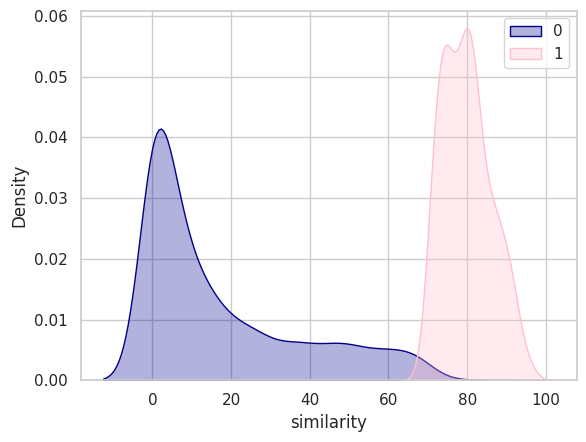

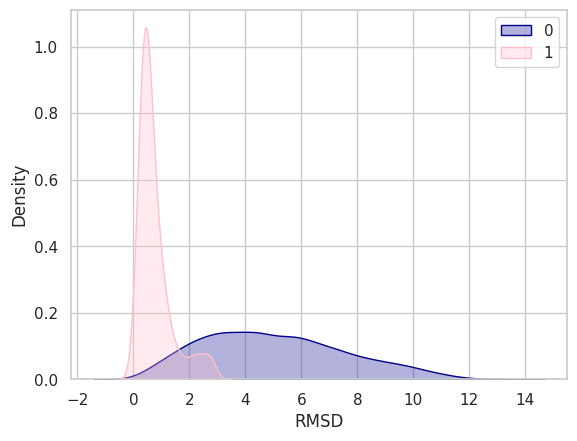

label.json saved at: ../Datahub/Data


In [103]:
%run Label.ipynb

In [104]:
#lig_atoms_prop["2xnb"][1].iloc[:, 1:]

In [105]:
label = pd.read_json(f"{config.data}/label.json").fillna(0)

In [106]:
len(label.columns)

284

In [107]:
class Get_dataset():
    def __init__(self, pdbs, lig_atoms_prop, rec_atoms_prop, df_dict, subsample=None, preprocessed_protgraph=False):
        self.pdbs = pdbs
        self.lig_atoms_prop = lig_atoms_prop
        self.rec_atoms_prop = rec_atoms_prop
        self.df_dict = df_dict
        self.protgraph_dict = self.get_unique_prot_graphs()
        self.preprocessed_protgraph=preprocessed_protgraph
        self.subsample = subsample 
        
    def map_node_names_to_indices(self, edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index
        
    def get_unique_prot_graphs(self):
        protgraph_dict = {}
        failed_protgraph = []

        for pdb in self.pdbs:
            protgraph_dict[pdb] = {}
            for pose in range(1, nposes + 1):
                try:
                    x_s = torch.tensor(np.array(self.lig_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    x_t = torch.tensor(np.array(self.rec_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    edge_index = torch.tensor(np.array([self.df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),
                                                    self.df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))
                
                    edge_index = self.map_node_names_to_indices(edge_index)
                    distances = torch.tensor(np.array(self.df_dict[pdb][pose]['distance']).astype("float32"))

                    protgraph_dict[pdb][pose] = {'x_s': x_s, # Ligand
                                             'x_t': x_t, # Receptor
                                             'edge_index': edge_index,
                                             'edge_attr': distances,
                                             }
                except Exception as e:
                    print('Error')
                    continue
        return protgraph_dict


    def process(self):
        print('processessing....')
        if self.preprocessed_protgraph:
            with open(f'{config.root}/{config.project_name}/protgraph_dict.pkl','rb') as f:
               protgraph_dict = pickle.load(f)
        else:
            protgraph_dict = self.get_unique_prot_graphs()
            with open(f'{config.root}/{config.project_name}/protgraph_dict.pkl','wb') as f:
                pickle.dump(protgraph_dict,f)
         
        for pdb in pdbs:
            for pose in range(1, nposes + 1): 

                protgraph = self.protgraph_dict[pdb][pose] ### Needs alteration to open saved dict, lets got with it righ now

                interaction_id = str(pdb) + "_" + str(pose)                 
     
                x_s, x_t, edge_index, edge_attr= protgraph['x_s'], protgraph['x_t'], protgraph['edge_index'],protgraph['edge_attr']

                #y = torch.randint(2, (1,), dtype=torch.float32)
                try:
                    y = torch.tensor(label[pdb][pose], dtype=torch.float32)
                except Exception as e:
                    print(f"Error: {e}")
                    continue
                #y = label[pdb][pose].astype("float32")
                data = BipartiteData(edge_index=edge_index, x_s=x_s, x_t=x_t, y=y, edge_attr = edge_attr, pdb = pdb, pose = pose)
                print(f'saving data {config.processed_dir}')
                torch.save(data, os.path.join(config.processed_dir, f'data_{interaction_id}.pt'))    

    
    def processed_file_names(self):
        datalist =   [torch.load(os.path.join(config.processed_dir, f'{filename}')) for filename in os.listdir(config.processed_dir)]
        return datalist

   # def __len__(self):
   #     return len(protgraph_dict)  ###
   # 
   #def __getitem__(self, index):
   #    pdb = self.pdbs[index]
   #    pose = 1  # You may need to modify this
   #    data_sample = self.protgraph_dict[pdb][pose]
   #    return data_sample

  

dataset = Get_dataset(pdbs, lig_atoms_prop, rec_atoms_prop, df_dict)

In [108]:
#dataset.get_unique_prot_graphs()['3gv9'][1]['edge_index'].shape

#### BipartiteData 

In [7]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

#### Dataset

In [110]:
%%time
dataset.process()
dataset_list = dataset.processed_file_names()

processessing....
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datahub/processed_dir
saving data ../Datah

In [111]:
import torch.nn.functional as F

"possible_atoms": ['C', 'S', 'N', 'O', 'H']

In [112]:
len(dataset_list)

2840

In [113]:
dataset_list[5].x_s[0:5]

tensor([[0., 2., 2., 0., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0., 1.]])

In [85]:
dataset_list[5].x_t[0:5]

tensor([[0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [86]:
for test in dataset_list:
    if test.pdb == '3zsx':
        print(test)

BipartiteData(edge_index=[2, 77], x_s=[77, 7], x_t=[77, 86], y=0.0, edge_attr=[77], num_nodes=154, pdb='3zsx', pose=6)
BipartiteData(edge_index=[2, 77], x_s=[77, 7], x_t=[77, 86], y=0.0, edge_attr=[77], num_nodes=154, pdb='3zsx', pose=9)
BipartiteData(edge_index=[2, 77], x_s=[77, 7], x_t=[77, 86], y=0.0, edge_attr=[77], num_nodes=154, pdb='3zsx', pose=4)
BipartiteData(edge_index=[2, 78], x_s=[78, 7], x_t=[78, 86], y=0.0, edge_attr=[78], num_nodes=156, pdb='3zsx', pose=1)
BipartiteData(edge_index=[2, 74], x_s=[74, 7], x_t=[74, 86], y=0.0, edge_attr=[74], num_nodes=148, pdb='3zsx', pose=3)
BipartiteData(edge_index=[2, 65], x_s=[65, 7], x_t=[65, 86], y=0.0, edge_attr=[65], num_nodes=130, pdb='3zsx', pose=8)
BipartiteData(edge_index=[2, 79], x_s=[79, 7], x_t=[79, 86], y=0.0, edge_attr=[79], num_nodes=158, pdb='3zsx', pose=7)
BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 86], y=0.0, edge_attr=[0], num_nodes=0, pdb='3zsx', pose=10)
BipartiteData(edge_index=[2, 73], x_s=[73, 7], x_t=[7

In [182]:
len(dataset_list[0].x_t)

110

In [183]:
len(rec_4eor_pose_1)

88

In [184]:
config.node_descriptors

['Mass',
 'Charge',
 'Element_Name',
 'Hybridization',
 'Num_Hydrogens',
 'Formal_Charge',
 'Unpaired_Electron',
 'In_Aromatic_Substructure']

In [185]:
dataset_list[6].x_t[0:10]

tensor([], size=(0, 86))

In [186]:
rec_4eor_pose_1.head(10)

,Mass,Charge,Element_Name,Hybridization,Num_Hydrogens,Formal_Charge,Unpaired_Electron,In_Aromatic_Substructure
0,12.011,0,0,3,3,0,0,0
1,12.011,0,0,3,3,0,0,0
2,12.011,0,0,3,3,0,0,0
3,12.011,0,0,3,3,0,0,0
4,15.999,0,3,2,0,0,0,0
5,12.011,0,0,3,3,0,0,0
6,12.011,0,0,3,3,0,0,0
7,12.011,0,0,3,3,0,0,0
8,12.011,0,0,3,3,0,0,0
9,12.011,0,0,3,3,0,0,0


In [187]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance
0,4eor,1,1.0,C2,92.0,CG2,3.537490
1,4eor,1,1.0,C2,1056.0,CD2,3.918316
2,4eor,1,3.0,N1,92.0,CG2,3.659126
3,4eor,1,3.0,N1,93.0,CD1,3.711112
4,4eor,1,3.0,N1,639.0,O,3.983377


### Saving pkl 

In [114]:
data_frame_docked['pose'].value_counts().reset_index(name = "count_nodes").sort_values('index')

,index,count_nodes
0,1,33930
1,2,30931
2,3,29823
3,4,28908
4,5,27755
5,6,27284
6,7,26126
7,8,25427
8,9,23866


In [115]:
pdb = '4j28'
pose = 7

In [116]:
ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"

In [117]:
molecule = Chem.MolFromPDBFile(protein_path, removeHs=False)

[16:12:46] Explicit valence for atom # 0 N, 5, is greater than permitted


In [118]:
molecule

In [119]:
dataset_list[2]

BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='3e93', pose=8)

In [120]:
dataset_list[6] # pose 1 

BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='4kzu', pose=7)

In [121]:
dataset_list

[BipartiteData(edge_index=[2, 110], x_s=[110, 7], x_t=[110, 7], y=0.0, edge_attr=[110], num_nodes=220, pdb='1nc1', pose=5),
 BipartiteData(edge_index=[2, 62], x_s=[62, 7], x_t=[62, 7], y=0.0, edge_attr=[62], num_nodes=124, pdb='1w4o', pose=3),
 BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='3e93', pose=8),
 BipartiteData(edge_index=[2, 123], x_s=[123, 7], x_t=[123, 7], y=0.0, edge_attr=[123], num_nodes=246, pdb='3b5r', pose=6),
 BipartiteData(edge_index=[2, 80], x_s=[0, 7], x_t=[80, 7], y=0.0, edge_attr=[80], num_nodes=80, pdb='5c2h', pose=9),
 BipartiteData(edge_index=[2, 92], x_s=[92, 7], x_t=[92, 7], y=1.0, edge_attr=[92], num_nodes=184, pdb='1e66', pose=1),
 BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='4kzu', pose=7),
 BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='3g2n', pose=10),
 BipartiteData(edge_index=[2, 59], x_s=[59, 7], x_t

In [122]:
import pickle

In [123]:
# Save the list to a file
with open(f'{config.data}/bipartite_data_name_type.pkl', 'wb') as file:
    pickle.dump(dataset_list, file)
    print('Saved with sucess!')

Saved with sucess!


In [124]:
dataset_list[4].x_s#[0:10]

tensor([], size=(0, 7))

#### Opening pkl 

In [8]:
with open(f'{config.data}/bipartite_data_name_type.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

2840

## Dataset info 

In [10]:
##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

In [11]:
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

In [12]:
len(filtered_data_list)

1948

In [44]:
len(set(pdbs) - set(proper_order))

27

In [36]:
proper_order = list(pd.read_csv('/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Data/depara_pdb_protein_name.csv').sort_values('Protein name')['PDB code'])

In [37]:
def pdb_index(item):
    proper_order.index(item.pdb)
    return order 

sorted_bipartite_data = sorted(filtered_data_list, key=pdb_index)

ValueError: '3d6q' is not in list

In [28]:
proper_order.index('2hs1')

2

In [141]:
config.node_descriptors

['Mass',
 'Charge',
 'Element_Name',
 'Hybridization',
 'Num_Hydrogens',
 'Formal_Charge',
 'Unpaired_Electron',
 'In_Aromatic_Substructure']

In [142]:
filtered_data_list[5].x_s[0:10]

tensor([[0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 2., 2., 0., 0., 0., 0.],
        [0., 2., 2., 0., 0., 0., 0.]])

In [143]:
import torch

def apply_one_hot_encoding_to_tensor(tensor, column_index, num_classes):
    column_data = tensor[:, column_index]
     
    one_hot_encoded = torch.nn.functional.one_hot(column_data.to(torch.int64), num_classes=num_classes)
    tensor = torch.cat((tensor, one_hot_encoded.float()), dim=1)
    tensor = torch.cat((tensor[:, :column_index], tensor[:, column_index + 1:]), dim=1)
 
        
    return tensor

def apply_one_hot_encoding_to_data(data_list, column_index, num_classes):
    i = 0 
    for index, data in enumerate(data_list):
        try:
            data.x_s = apply_one_hot_encoding_to_tensor(data.x_s, column_index, num_classes)
            data.x_t = apply_one_hot_encoding_to_tensor(data.x_t, column_index, num_classes)
        except Exception as e:
            print('Error: ', e, 'index', index)
            i += 1
    print('Total erros: ', i )

#### One-hot-enconding-Element_Name

In [144]:
apply_one_hot_encoding_to_data(filtered_data_list, column_index=1, num_classes=5)

Total erros:  0


['Charge',
 'Element_Name',
 'Hybridization',
 'Num_Hydrogens',
 'Formal_Charge',
 'Unpaired_Electron',
 'In_Aromatic_Substructure']

In [145]:
filtered_data_list[5].x_s[0:10]

tensor([[0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 2., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [146]:
filtered_data_list[5].x_t[0:10].shape

torch.Size([10, 11])

In [147]:
# import numpy as np
# 
# # Aggregate all x_s attributes from all BipartiteData objects into a single numpy array
# all_x_t = np.concatenate([data.x_t for data in filtered_data_list])
# all_x_s = np.concatenate([data.x_s for data in filtered_data_list])
# 
# 
# # Calculate the minimum and maximum values across all x_s attributes
# min_val_x_s = all_x_s.min()
# max_val_x_s = all_x_s.max()
# 
# min_val_x_t = all_x_t.min()
# max_val_x_t = all_x_t.max()
# 
# max_val  = max(max_val_x_s, max_val_x_t)
# min_val  = min(min_val_x_s, min_val_x_t)
# 
# print("min_val xs", min_val_x_s)
# print('max_val xs ', max_val_x_s)
# 
# 
# print("min_val x_t", min_val_x_t)
# print('max_val x_t', max_val_x_t)
# 
# 
# print("min_val", min_val)
# print('max_val', max_val)
# # Apply min-max normalization to each BipartiteData object
# for data in filtered_data_list:
#     normalized_x_s = (data.x_s - min_val) / (max_val - min_val)
#     normalized_x_t = (data.x_t - min_val) / (max_val - min_val)
#     
#     data.x_s = np.round(normalized_x_s,2)
#     data.x_t = np.round(normalized_x_t,2)

In [148]:
print(5*"*******")
print("Dataset 2016: 285")
print("Docked complexes: ", len(pdbs))
print("Nº of poses generated: ", len(dataset_list))
#print("Nº graphs with features: ", len(filtered_data_list_num_nodes))
print("Nº Dataset to train ", len(filtered_data_list))
print(5*"*******")

***********************************
Dataset 2016: 285
Docked complexes:  284
Nº of poses generated:  2840
Nº Dataset to train  1948
***********************************


### Saving pkl 

In [149]:
filtered_data_list[1].x_s[0:10]

tensor([[0., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 3., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 0.]])

In [290]:
import pickle

In [150]:
## Save the list to a file
#with open(f'{config.data}/bipartite_data_name_normalized.pkl', 'wb') as file:
#    pickle.dump(filtered_data_list, file)
#    print('Saved with sucess!')

Saved with sucess!


| Priority | Status      | Task Description                                |
|----------|-------------|-------------------------------------------------|
| 1        | To Do       | -   label                              |
|          |             |   - Problem of rmsd                            |
|          |             |   - Put rmsd method: rdkit                     |
| 1        | To Do       | - Model descriptors                            |
|          |             |   - Nodes meaning                                |
| 2        | To Do       | - Add more metrics                             |
| 2        | To Do       | - Print more metrics                           |
| 3        | To Do       | - Cross-validation method as info              |
| 3        | To Do       | - Revise split methods                         |
| 4        | To Do       | - See what binna considers as close contact    |
| 5        | To Do       | - Clean code                                   |
| 5        | To Do       | - Comment code                                 |
| 5        | To Do       | - Process all data                             |


##### Figure 3: Cumulative fraction of results with crystal-like (within 2 Å RMSD) binding mode plotted versus pose number as ranked

Cumulative fraction of systems that contain at least one correct pose up to a given pose number.

    For example, at x=5, the y-values indicate the fraction of systems that have at least one 
    “positive” pose in the top 5 according to the rankings specified by each model. 
    
    It can be seen that the “L+LP+R” model maintains roughly the advantage seen on the first pose until approximately x=10, where all plots in Figure 3 start to level off. In 65% of systems in our test set, the docking program samples a correct mode in at least one of the 20 rank positions.

* CB: Beta carbon atom in amino acids.
* N: Nitrogen atom.
* O: Oxygen atom.
* CD1: Side chain carbon atom in amino acids.
* CA: Alpha carbon atom in amino acids.
* CG2: Side chain carbon atom in amino acids.
* CG: Side chain carbon atom in amino acids.
* CD2: Side chain carbon atom in amino acids.
* C: Carbon atom.
* CZ: Side chain carbon atom in amino acids.
* CG1: Side chain carbon atom in amino acids.
* OD1: Oxygen atom in amino acids.
* CE1: Side chain carbon atom in amino acids.
* OD2: Oxygen atom in amino acids.
* NZ: Side chain nitrogen atom in amino acids.
* CD: Carbon atom in amino acids.
* ND2: Side chain nitrogen atom in amino acids.
* CE2: Side chain carbon atom in amino acids.
* NE2: Side chain nitrogen atom in amino acids.
* OE1: Oxygen atom in amino acids.
* OH: Hydroxyl group.
* CE: Side chain carbon atom in amino acids.
* NE: Side chain nitrogen atom in amino acids.
* NH2: Amine group.
* OG1: Oxygen atom in amino acids.
* OE2: Oxygen atom in amino acids.
* OG: Oxygen atom in amino acids.
* SD: Sulfur atom.
* SG: Sulfur atom.
* ND1: Side chain nitrogen atom in amino acids.
* NH1: Amine group.
